# 应用：人脸识别管道

本节将会介绍一种图像特征提取技术：HOG，方向梯度直方图。  
其可以将图像像素转换成向量形式，与图像具体内容有关，但是与图像合成因素无关  
整一篇代码中出现了很多warning

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

## HOG 特征
HOG 是一个简单的特征提取程序，专门用来识别有行人的图像内容，包含以下五个步骤：

* 图像标准化（可选），消除照度（亮度？）对图像的影响
* 用与水平和垂直方向的亮度梯度相关的两个过滤器处理图像，捕捉图像的边，角，和纹理信息
* 将图像切割成预定义大小的图块，然后计算每个图块内梯度方向的频次直方图
* 对比每个图块与相邻图块的频次直方图，做标准化处理，进一步消除照度对图像的影响
* 获得描述每个图块信息的一维特征向量

Text(0.5, 1.0, 'visualization of HOG features')

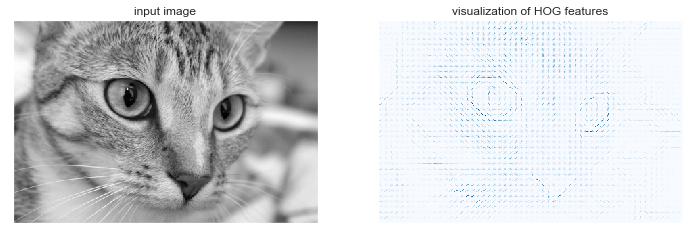

In [2]:
from skimage import data, color, feature
import skimage.data

image = color.rgb2gray(data.chelsea())
hog_vec, hog_vis = feature.hog(image, visualize=True, block_norm='L1')

fig, ax = plt.subplots(1, 2, figsize=(12,6),
                      subplot_kw=dict(xticks=[], yticks=[]))
ax[0].imshow(image, cmap='gray')
ax[0].set_title('input image')

ax[1].imshow(hog_vis, cmap='Blues')
ax[1].set_title('visualization of HOG features')

## 简单的人脸识别器

有了这么一个一维特征后，就可以用sklearn的任意评估器建立简单人脸识别算法，这里使用线性支持向量机，步骤如下：
* 获取一组人脸图像缩略图，构建”正“训练样本
* 获取另一组人脸图像缩略图，构建”负“训练样本
* 提取训练样本的HOG特征
* 对样本训练的一个线性SVM
* 为”未知“图像传递一个移动的窗口，用模型评估窗口中的内容是否是人脸
* 如果发现和已知图像重叠，就将它们组合成一个窗口

### 获取一组正训练样本

In [3]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people()
positive_patches = faces.images
# 获取了 13000+ 张照片
positive_patches.shape

(13233, 62, 47)

### 获取一组负训练样本

要获取近似大小的缩略图，所以要引入别的图像数据，并且缩略到差不多的大小

In [4]:
from skimage import data, transform

imgs_to_use = ['camera','text','coins','moon',
              'page','clock','immunohistochemistry',
               'chelsea','coffee','hubble_deep_field']

images = [color.rgb2gray(getattr(data, name)())
          for name in imgs_to_use]

In [5]:
from sklearn.feature_extraction.image import PatchExtractor

def extract_patches(img, N, scale=1.0,
                   patch_size=positive_patches[0].shape):
    extracted_patch_size = \
    tuple((scale * np.array(patch_size)).astype(int))
    
    extractor = PatchExtractor(patch_size=extracted_patch_size,
                              max_patches=N, random_state=0)
    patches = extractor.transform(img[np.newaxis])
    if scale != 0:
        patches = np.array([transform.resize(patch, patch_size, mode='constant', anti_aliasing =True)
                           for patch in patches])
    return patches

In [6]:
negative_patches = np.vstack([extract_patches(im, 1000, scale)
                             for im in images for scale in [0.5, 1.0, 2.0]])
negative_patches.shape

(30000, 62, 47)

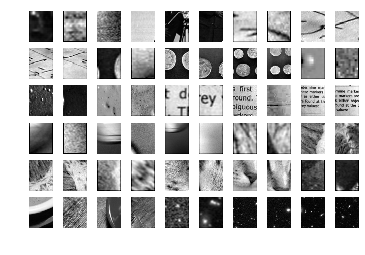

In [7]:
fig, ax = plt.subplots(6, 10)
for i, axi in enumerate(ax.flat):
    axi.imshow(negative_patches[500 * i], cmap = 'gray')
    axi.axis('off')

### 组合数据集并提取HOG特征

In [8]:
from itertools import chain
X_train = np.array([feature.hog(im, block_norm='L1')
                   for im in chain(positive_patches,negative_patches)])
y_train = np.zeros(X_train.shape[0])
y_train[:positive_patches.shape[0]] = 1

In [9]:
X_train.shape

(43233, 1215)

### 训练一个支持向量机

对于高维度的二元分类，用线性支持向量机是个不错的选择，这里使用LinearSVC，因为它比SVC更加适合处理大样本数据

先用高斯朴素贝叶斯分类器算一个初始解

In [10]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

cross_val_score(GaussianNB(), X_train, y_train, cv=3)

array([0.93706197, 0.8435917 , 0.93942128])

再用支持向量机训练

In [11]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(LinearSVC(), {'C': [1.0, 2.0, 4.0, 8.0]}, cv=3)
grid.fit(X_train, y_train)
grid.best_score_

0.9861911040177642

In [12]:
grid.best_params_

{'C': 2.0}

In [13]:
model = grid.best_estimator_
model.fit(X_train, y_train)

LinearSVC(C=2.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

### 在新图像中寻找人脸

(-0.5, 139.5, 159.5, -0.5)

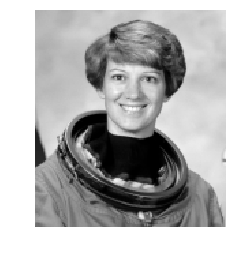

In [14]:
test_image = skimage.data.astronaut()
test_image = skimage.color.rgb2gray(test_image)
test_image = skimage.transform.rescale(test_image, 0.5, multichannel=False, 
                                       mode='constant',anti_aliasing=True)
test_image = test_image[:160, 40:180]

plt.imshow(test_image, cmap = 'gray')
plt.axis('off')

创建一个不断在图像中移动的窗口，然后计算每次移动位置的HOG特征

In [15]:
def sliding_window(img, patch_size=positive_patches[0].shape, 
                  istep=2, jstep=2, scale=1.0):
    Ni, Nj = (int(scale * s) for s in patch_size)
    for i in range(0, img.shape[0] - Ni, istep):
        for j in range(0, img.shape[1] - Ni, jstep):
            patch = img[i:i+Ni, j:j+Nj]
            if scale != 1:
                patch = transform.resize(patch, patch_size, 
                                        mode='constant', anti_aliasing =True,
                                        block_norm = 'L1')
            yield (i,j), patch

indices, patches = zip(*sliding_window(test_image))
patches_hog = np.array([feature.hog(patch,block_norm='L1') for patch in patches])
patches_hog.shape

(1911, 1215)

In [16]:
feature.hog?

收集这些Hog特征，并用训练好的模型来评估每个窗口中是否有人脸

In [17]:
labels = model.predict(patches_hog)

In [18]:
labels.sum()

31.0

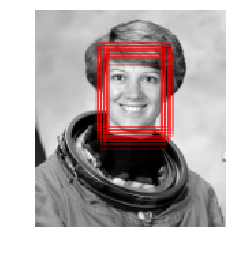

In [19]:
fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')
ax.axis('off')

Ni, Nj = positive_patches[0].shape
indices = np.array(indices)

for i, j in indices[labels == 1]:
    ax.add_patch(plt.Rectangle((j,i), Nj, Ni,edgecolor='red',
                              alpha = 0.2, lw=2,
                              facecolor='none'))

最终成功找到人脸

## 注意事项和改进方案

* 训练集，尤其是负样本，并不完善，可以通过人工标注识别错误的图像放入样本训练，使得更精确
* 现在的管道只能搜索一个尺寸，可以搜索多个尺寸，然后用resize
* 应该将重叠窗口合并，可以通过一个无监督的聚类方法实现
* 管道可以更具流线型
* 可以利用深度学习做